# Ecualización de histogramas

> La ecualización de histogramas es un método de procesamiento de imágenes o ajuste de contraste que utiliza el histograma de la imagen.

Considere una imagen cuyos valores de píxel se limitan únicamente a un rango específico de valores. Por ejemplo, una imagen más brillante tendrá todos los píxeles confinados a valores altos. Pero una buena imagen tendrá píxeles de todas las regiones de la imagen. Por lo tanto, debe estirar este histograma hacia ambos extremos (como se muestra en la imagen a continuación, de wikipedia) y eso es lo que hace la ecualización de histogramas (en palabras simples). Esto normalmente mejora el contraste de la imagen. 

![histograma - antes y después de la equalización](assets/pictures/2.png)

Acontinuación se muestra el histograma de la siguente imagen

![Antes de la equalización](assets/pruebas/Unequalized_Hawkes_Bay_NZ.jpg)


In [2]:
#importación de librerías
import numpy as np
import cv2 as cv
from PIL import Image
from matplotlib import pyplot as plt

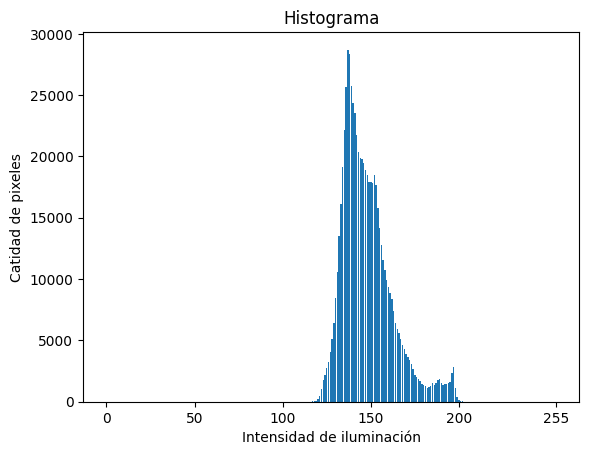

In [3]:

def graficar(datos, imagen):
   
    plt.figure(1)
    x=range(len(datos))
    plt.xticks([0, 50, 100, 150, 200, 255],[0, 50, 100, 150, 200, 255])
    plt.bar(x, datos, align='center')
    plt.title('Histograma')
    plt.xlabel('Intensidad de iluminación')
    plt.ylabel('Catidad de pixeles')
    
    plt.savefig(imagen, bbox_inches='tight')

    return None

foto=Image.open('assets/pruebas/Unequalized_Hawkes_Bay_NZ.jpg')

#si la imagen es a color la convertimos a escala de grises
if foto.mode != 'L':
    foto=foto.convert('L')

histograma=foto.histogram()

graficar(histograma, 'assets/pruebas/h0.jpg')


* implementación de Numpy para normalizar la imagen

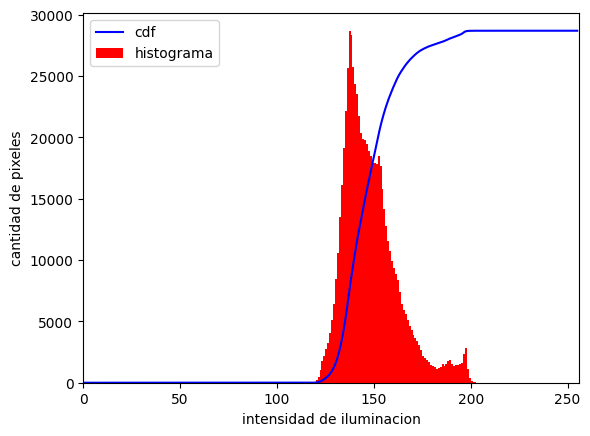

<Figure size 640x480 with 0 Axes>

In [4]:

img = cv.imread('assets/pruebas/Unequalized_Hawkes_Bay_NZ.jpg',0)
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histograma'), loc = 'upper left')
plt.xlabel('intensidad de iluminacion')
plt.ylabel('cantidad de pixeles')
plt.show()
plt.savefig('assets/pruebas/h1.png', bbox_inches='tight')

Puede ver que el histograma se encuentra en la región más brillante. Necesitamos el espectro completo. Para eso, necesitamos una función de transformación que mapee los ***píxeles de entrada en la región más brillante a los píxeles de salida en la región completa***. Eso es lo que hace la ecualización de histogramas.

* Encontrar el valor mínimo del histograma (excluyendo 0)
* Aplicar la ecuación de ecualización del histogram
![función de equalización](assets/pictures/fun_ec.svg)

Pero aquí he usado el concepto de matriz enmascarada de Numpy. 

📑**Nota**: Para una matriz enmascarada, todas las operaciones se realizan en elementos no enmascarados. Puede leer más sobre esto en los documentos de Numpy sobre matrices enmascaradas.

In [5]:
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')

Ahora tenemos la tabla de búsqueda que nos brinda información sobre cuál es el valor de píxel de salida para cada valor de píxel de entrada. Así que acabamos de aplicar la transformación.

In [6]:
img2 = cdf[img]

Ahora calculamos su histograma y cdf como antes y el resultado se ve a continuación

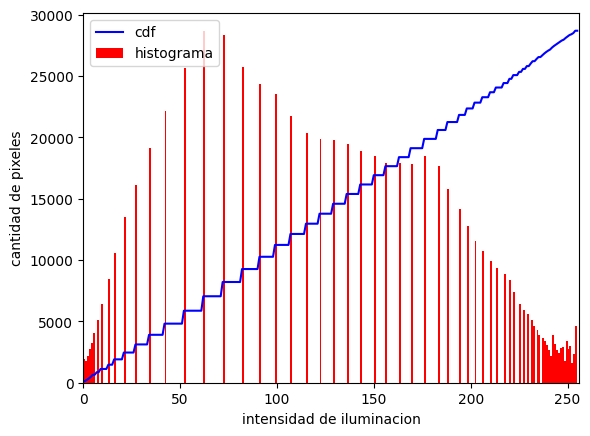

<Figure size 640x480 with 0 Axes>

In [7]:

#img = cv.imread('assets/pruebas/Unequalized_Hawkes_Bay_NZ.jpg',0)
hist,bins = np.histogram(img2.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img2.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histograma'), loc = 'upper left')
plt.xlabel('intensidad de iluminacion')
plt.ylabel('cantidad de pixeles')
plt.show()
plt.savefig('assets/pruebas/h2.png')

Otra característica importante es que, incluso si la imagen era una imagen más oscura (en lugar de una más brillante que usamos), después de la ecualización obtendremos casi la misma imagen que obtuvimos. Como resultado, esto se utiliza como una "herramienta de referencia" para hacer todas las imágenes con las mismas condiciones de iluminación. Esto es útil en muchos casos. Por ejemplo, en el reconocimiento facial, antes de entrenar los datos faciales, se ecualiza el histograma de las imágenes de los rostros para que todos tengan las mismas condiciones de iluminación.

# Ecualización de histogramas en OpenCV

OpenCV tiene una función para hacer esto, ***cv.equalizeHist()***. Su entrada es solo una imagen en escala de grises y la salida es nuestra imagen ecualizada de histograma.

A continuación se muestra un fragmento de código simple que muestra su uso para la misma imagen que usamos:

In [8]:
img = cv.imread('assets/pruebas/Unequalized_Hawkes_Bay_NZ.jpg',0)
equ = cv.equalizeHist(img)
res = np.hstack((img,equ)) #stacking images side-by-side
cv.imwrite('assets/pruebas/Compare_Hawkes_Bay_NZ.jpg',res)

True

📑 **Nota**: La ecualización del histograma es buena cuando el histograma de la imagen se limita a una región en particular. No funcionará bien en lugares donde hay grandes variaciones de intensidad donde el histograma cubre una gran región, es decir, están presentes píxeles brillantes y oscuros.

# CLAHE (Contrast Limited Adaptive Histogram Equalization) 

> ecualización de histograma adaptativo limitado por contraste

La primera ecualización de histograma que acabamos de ver considera el contraste global de la imagen. En muchos casos, no es una buena idea. Por ejemplo, la siguiente imagen muestra una imagen de entrada y su resultado después de la ecualización global del histograma.

![clahe_1](assets/pruebas/clahe_1.jpg)

Es cierto que el contraste de fondo ha mejorado tras la ecualización del histograma. Pero compare la cara de la estatua en ambas imágenes. Perdimos la mayor parte de la información allí debido al exceso de brillo. Es porque su histograma no se limita a una región en particular como vimos en casos anteriores (intente trazar el histograma de la imagen de entrada, obtendrá más intuición).

Entonces, para resolver este problema, se usa la **ecualización de histograma adaptativo**. 
1. La imagen se divide en pequeños bloques llamados "mosaicos" (tileSize es 8x8 por defecto en OpenCV).
2. Cada uno de estos bloques se iguala en histograma como de costumbre. 
3. Entonces, el histograma se limitaría a una región pequeña (a menos que haya ruido).
    * Si hay ruido, se amplificará. Para evitar esto, se aplica la limitación de contraste. 
4. Si algún bin de histograma está por encima del límite de contraste especificado (por defecto 40 en OpenCV), esos píxeles se recortan y distribuyen uniformemente a otros bins antes de aplicar la ecualización de histograma. 
5. Después de la ecualización, para eliminar los artefactos en los bordes de los mosaicos, se aplica la interpolación bilineal.

In [9]:

img = cv.imread('assets/pruebas/tsukuba_1.png',0)
# create a CLAHE object (Arguments are optional).
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)
cv.imwrite('assets/pruebas/tsukuba_2.png',cl1)

True

![tsukuba1](assets/pruebas/tsukuba_1.png) ![tsukuba2](assets/pruebas/tsukuba_2.png)

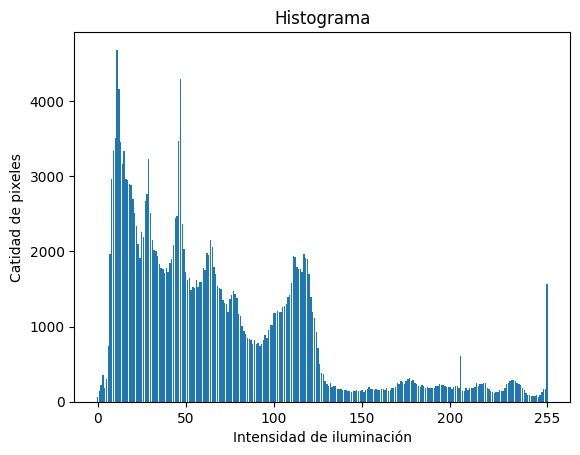

In [11]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

def graficar(datos, imagen):
   
    plt.figure(1)
    x=range(len(datos))
    plt.xticks([0, 50, 100, 150, 200, 255],[0, 50, 100, 150, 200, 255])
    plt.bar(x, datos, align='center')
    plt.title('Histograma')
    plt.xlabel('Intensidad de iluminación')
    plt.ylabel('Catidad de pixeles')
    
    #plt.savefig(imagen, bbox_inches='tight')

    return None

foto=Image.open('assets/pruebas/tsukuba_1.png')

#si la imagen es a color la convertimos a escala de grises
if foto.mode != 'L':
    foto=foto.convert('L')

histograma=foto.histogram()

graficar(histograma, 'assets/pruebas/h0.jpg')